<a href="https://colab.research.google.com/github/lephuocdat2000/Advanced-CV/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import cv2
import timeit
import itertools 

Compile darknet

In [24]:
%cd /content/drive/My\ Drive/darknet
!rm darknet
!make

/content/drive/My Drive/darknet
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:935:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1136:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

In [25]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

In [37]:
def load_network_1(config_file, data_file, weights, batch_size=1):
    """
    load model description and weights from config files
    args:
        config_file (str): path to .cfg model file
        data_file (str): path to .data model file
        weights (str): path to weights
    returns:
        network: trained model
        class_names
        class_colors
    """
    network = load_net_custom(
        config_file.encode("ascii"),
        weights.encode("ascii"), 0, batch_size)
    metadata = load_meta(data_file.encode("ascii"))
    class_names = [metadata.names[i].decode("ascii") for i in range(1)]
    colors = class_colors(class_names)
    return network, class_names, colors

def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  boxes = np.array([bbox2points(bbox) for _,_,bbox in detections])
  boxes = boxes * [width_ratio, height_ratio, width_ratio, height_ratio]
  return boxes

def MatrixCreation(A,B,C,D):
    width = int(max(np.sqrt((B[1]-A[1])**2+(B[0]-A[0])**2),np.sqrt((D[1]-C[1])**2+(D[0]-C[0])**2)))
    height = int(max(np.sqrt((C[1]-A[1])**2+(C[0]-A[0])**2),np.sqrt((D[1]-B[1])**2+(D[0]-B[0])**2)))
    inputs = np.float32([A,B,C,D])
    outputs = np.float32([[0,0],
                      [width-1,0],
                      [0,height-1],
                      [width-1,height-1]])
    M = cv2.getPerspectiveTransform(inputs,outputs)
    return M,width,height

def Points_Transformation(boxes):
    x_ = boxes[:,0]+(boxes[:,2]-boxes[:,0]) / 2
    # y_ = boxes[:,1]+(boxes[:,3]-boxes[:,1]) / 2
    y_ = boxes[:,3]
    x_ = np.expand_dims(x_,axis = 1)
    y_ = np.expand_dims(y_,axis = 1) 
    # centroids = np.uint32(np.concatenate((x_,y_),axis=1))
    centroids = np.concatenate((x_,y_),axis=1)
    list_point_to_detect = centroids.reshape(-1,1,2)
    transformed_points = cv2.perspectiveTransform(list_point_to_detect, M)
    transformed_points = transformed_points.reshape(transformed_points.shape[0],transformed_points.shape[2])
    return transformed_points

def DrawnRectangel(boxes,image,point,color):
    # xmin,ymin,xmax,ymax = int(boxes[point][0]),int(boxes[point][1]),int(boxes[point][2]),int(boxes[point][3])
    xmin,ymin,xmax,ymax = boxes[point][:].astype(int)
    cv2.rectangle(image,(int(xmin),int(ymin)),(int(xmax),int(ymax)),color,2)  

def get_birds_eye_view_image(transformed_points,green_box,red_box,eye_view_height,eye_view_width):
    blank_image = cv2.imread('/content/drive/MyDrive/Advanced-CV/black_background.png')
    blank_image = cv2.resize(blank_image,(eye_view_width,eye_view_height))
    cv2.putText(blank_image, str(len(red_box)), (120,100), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,0,255), 4, cv2.LINE_AA) 
    cv2.putText(blank_image, str(len(green_box)), (520,100), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,255,0), 4, cv2.LINE_AA)
    for point in green_box:
        cv2.circle(blank_image,tuple(transformed_points[point].astype(int)),20,(0,255,0),-1)
    for point in red_box:
        cv2.circle(blank_image,tuple(transformed_points[point].astype(int)),20,(0,0,255),-1)
    blank_image = cv2.resize(blank_image,(eye_view_width//2,eye_view_height))
    return blank_image
     
def video_processing(video_path,real_width,real_height,pixel_width,pixel_height):
    cap = cv2.VideoCapture(video_path)
    if (cap.isOpened()==False): 
        print('Error opening video stream or file')
    else: 
      blank_image = cv2.imread('/content/drive/MyDrive/Advanced-CV/black_background.png')
      blank_image = cv2.resize(blank_image,(960,540))
      fourcc = cv2.VideoWriter_fourcc(*'DIVX')
      out = cv2.VideoWriter('output.avi',fourcc, 20, (1440,540))
      while (True):
          ret, frame = cap.read()
          if ret==True:
            alter_blank_image = blank_image.copy()
            boxes = darknet_helper(frame,width,height)  
            transformed_points = Points_Transformation(boxes)
            image_rect = frame.copy()
            if len(boxes) > 1:  
                list_indexes = list(itertools.combinations(range(len(transformed_points)), 2))
                x_y_ = []
                for i,pair in enumerate(itertools.combinations(transformed_points, r=2)):
                     if np.sqrt( ((pair[0][0] - pair[1][0])*real_width/pixel_width)**2 + ((pair[0][1] - pair[1][1])*real_height/pixel_height)**2  ) < int(distance_minimum):
                         index_pt1 = list_indexes[i][0]
                         index_pt2 = list_indexes[i][1]
                         if index_pt1 not in x_y_:
                            #draw red circle top view
                            cv2.circle(alter_blank_image,tuple(transformed_points[index_pt1].astype(int)),20,(0,0,255),-1)
                            #change red box original frame
                            DrawnRectangel(boxes,image_rect,index_pt1,(0,0,255))
                            x_y_.append(index_pt1)
                         if index_pt2 not in x_y_: 
                            #draw red circle top view    
                            cv2.circle(alter_blank_image,tuple(transformed_points[index_pt2].astype(int)),20,(0,0,255),-1)
                            #change red box original frame    
                            DrawnRectangel(boxes,image_rect,index_pt2,(0,0,255))
                            x_y_.append(index_pt2) 
                #select points to draw green box and green circle 
                diff = np.setdiff1d(list(range(0,len(boxes))),np.unique(x_y_))
                for i in diff:
                   DrawnRectangel(boxes,image_rect,i,(0,255,0))
                   cv2.circle(alter_blank_image,tuple(transformed_points[i].astype(int)),20,(0,255,0),-1)
            elif len(boxes)==1: 
                 DrawnRectangel(boxes,image_rect,0,(0,255,0))
                 cv2.circle(alter_blank_image,tuple(transformed_points[0].astype(int)),20,(0,255,0),-1)
            #Write nums of red
            height_blank,width_blank = alter_blank_image.shape[0],alter_blank_image.shape[1]
            cv2.putText(alter_blank_image, str(len(x_y_)), (int(width_blank*0.225),int(height_blank*0.1)), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,0,255), 4, cv2.LINE_AA) 
            #Write nums of green
            cv2.putText(alter_blank_image, str(len(diff)), (int(width_blank*0.7),int(height_blank*0.1)), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,255,0), 4, cv2.LINE_AA)
            alter_blank_image = cv2.resize(alter_blank_image,(alter_blank_image.shape[1]//2,alter_blank_image.shape[0]))
            combined_image = np.concatenate((alter_blank_image,image_rect),axis=1)
            out.write(combined_image)
            if cv2.waitKey(1)==ord('q'): break
          else: break 
    out.release()
    return
def show_webcam(mirror=False):
    vid = cv2.VideoCapture(0)
    while True:
       ret,frame = vid.read()
       plt.imshow('frame',frame)
       if cv2.waitKey(1) & 0xFF == ord('q'):
          break
    vid.release()
    cv2.destroyAllWindows() 


In [26]:
from darknet import *
  #608X608
  # load in our YOLOv4 architecture network
network, class_names, class_colors = load_network_1("cfg/yolov4.cfg", "cfg/coco.data", "yolov4.weights")
width = network_width(network)
height = network_height(network)



Test trên ảnh

[[969.53318156 467.08775898]
 [507.16037727 453.04808614]]


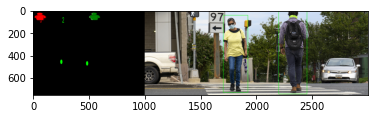

In [38]:
# Get transformation matrix
A = [470,330]
B = [980,310]
C = [310,700]
D = [1200,680]
distance_minimum = 2.0
real_width,real_height = 7.5,8.0
pixel_width,pixel_height = B[0] - A[0], C[1]-A[1]
M,pixel_width,pixel_height = MatrixCreation(A,B,C,D)

image = cv2.imread("/content/Pedestrian_mask.jpg")
boxes = darknet_helper(image, width, height)
transformed_points = Points_Transformation(boxes)
print(transformed_points)
if len(boxes) > 1:
    image_rect = image.copy()
    list_indexes = list(itertools.combinations(range(len(transformed_points)), 2))
    x_y_ = []
    for i,pair in enumerate(itertools.combinations(transformed_points, r=2)):
      if np.sqrt( ((pair[0][0] - pair[1][0])*real_width/pixel_width)**2 + ((pair[0][1] - pair[1][1])*real_height/pixel_height)**2  ) < int(distance_minimum):
      #change color top view
         index_pt1 = list_indexes[i][0]
         index_pt2 = list_indexes[i][1]
      #change color original frame
         DrawnRectangel(boxes,image_rect,index_pt1,(0,0,255))
         DrawnRectangel(boxes,image_rect,index_pt2,(0,0,255))
         x_y_.append(index_pt1)
         x_y_.append(index_pt2)
      diff = np.setdiff1d(list(range(0,len(boxes))),np.unique(x_y_))
      for i in diff: DrawnRectangel(boxes,image_rect,i,(0,255,0))
elif len(boxes)==1: 
    image_rect = image.copy()
    DrawnRectangel(boxes,image_rect,0,(0,255,0))
else: image_rect = image.copy()
birds_eye_view_image = get_birds_eye_view_image(transformed_points,diff,x_y_,image.shape[0],image.shape[1])
combined_image = np.concatenate((birds_eye_view_image,image_rect), axis=1)


Test video

In [35]:
%cd /content/drive/MyDrive/

A = [571,151]
B = [768,185]
C = [283,400]
D = [690,521]
M,pixel_width,pixel_height = MatrixCreation(A,B,C,D)
real_width,real_height = 4.0,7.6
distance_minimum = 2.0
video_path='/content/drive/MyDrive/Advanced-CV/Home7_42.m4v'
video_processing(video_path,real_width,real_height,pixel_width,pixel_height)

/content/drive/MyDrive


Test trên ảnh

4 points image

In [ ]:
def Distance(A,B):
   print(real_width,real_height)
   print(pixel_width,pixel_height)
   distance = np.sqrt(((A[0] - B[0])*real_width/pixel_width)**2 + ((A[1] - B[1])*real_height/pixel_height)**2)
   return distance
def Points_Transformation1(boxes):
    x_ = boxes[:,0]+(boxes[:,2]-boxes[:,0]) / 2
    # y_ = boxes[:,1]+(boxes[:,3]-boxes[:,1]) / 2
    y_ = boxes[:,1]+(boxes[:,3]-boxes[:,1])/2
    x_ = np.expand_dims(x_,axis = 1)
    y_ = np.expand_dims(y_,axis = 1) 
    # centroids = np.uint32(np.concatenate((x_,y_),axis=1))
    centroids = np.concatenate((x_,y_),axis=1)
    list_point_to_detect = centroids.reshape(-1,1,2)
    transformed_points = cv2.perspectiveTransform(list_point_to_detect, M)
    transformed_points = transformed_points.reshape(transformed_points.shape[0],transformed_points.shape[2])
    return transformed_points


In [ ]:
A = [1150,300]
B = [1570,360]
C = [560,800]
D = [1375,1050]
pts = np.array([A, C, D, B],np.int32)
isClosed = True
pts = pts.reshape((-1, 1, 2))
M,pixel_width,pixel_height = MatrixCreation(A,B,C,D)
real_width , real_height = 4.0, 7.6

image = cv2.imread('/content/201178778_375404177254763_2657893033887157176_n.png')
cv2.circle(image,tuple(A),10,(0,0,255),-1)
cv2.circle(image,tuple(B),10,(0,0,255),-1)
cv2.circle(image,tuple(C),10,(0,0,255),-1)
cv2.circle(image,tuple(D),10,(0,0,255),-1)
cv2.circle(image,tuple(center),10,(0,0,255),-1)
cv2.polylines(image, [pts], isClosed, (0,255,0), 4)

boxes = darknet_helper(image, width, height)
for (xmin,ymin,xmax,ymax) in boxes:
    cv2.rectangle(image,(int(xmin),int(ymin)),(int(xmax),int(ymax)),(0,255,0),2)

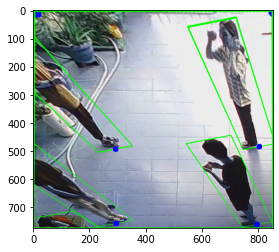

In [ ]:
warped_points = cv2.warpPerspective(image,M,(pixel_width,pixel_height))
Transformed_Points = Points_Transformation(boxes)
for point in Transformed_Points:
   cv2.circle(warped_points,tuple(point.astype(int)),10,(0,0,255),-1)
plt.imshow(warped_points)

4 points video

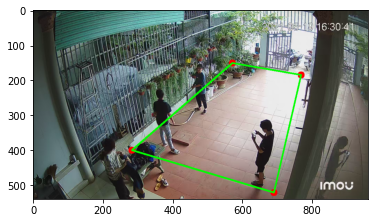

In [ ]:
A = [571,151]
B = [768,185]
C = [283,400]
D = [690,521]
pts = np.array([A, C, D, B],np.int32)
isClosed = True
pixel_widtd,pixel_height = B[0] - A[0], C[1]-A[1]
M = MatrixCreation(A,B,C,D)
cap = cv2.VideoCapture('/content/drive/MyDrive/Advanced-CV/Ảnh-20210620T080054Z-001/Ảnh/20210619163037500_7A090A0PAZ97646_L_44_L070619163037.mp4')
if (cap.isOpened()==False):
    print('Error opening video stream or file')
else: 
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    while (True):
       ret, frame = cap.read()
       if ret==True:
           frame = cv2.resize(frame,(960,540))
           out = cv2.VideoWriter('output.avi',fourcc, 24,(frame.shape[1],frame.shape[0]))
           cv2.circle(frame,tuple(A),10,(0,0,255),-1)
           cv2.circle(frame,tuple(B),10,(0,0,255),-1)
           cv2.circle(frame,tuple(C),10,(0,0,255),-1)
           cv2.circle(frame,tuple(D),10,(0,0,255),-1)
           cv2.polylines(frame, [pts], isClosed, (0,255,0), 4)
           plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
           #frame = cv2.warpPerspective(frame,M,(frame.shape[1],frame.shape[0]))
           break
           if cv2.waitKey(1)==ord('q'): break
           out.write(frame)
       else: break
    out.release()

#Model Validation

AP Metric

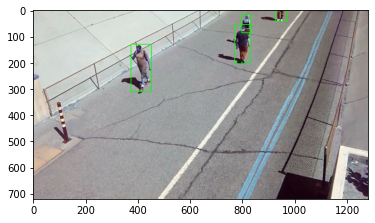

In [ ]:
image = cv2.imread('/content/frame8.jpg')

boxes = darknet_helper(image, width, height)
for (xmin,ymin,xmax,ymax) in boxes:
    cv2.rectangle(image,(int(xmin),int(ymin)),(int(xmax),int(ymax)),(0,255,0),2)
plt.imshow(image)
plt.show()   

In [ ]:
def IOU_Calculation(gt_bbox,pred_bbox):
  xmin_gt,ymin_gt,xmax_gt,ymax_gt = gt_bbox
  xmin_pre,ymin_pre,xmax_pre,ymax_pre = pred_bbox
  if (xmax_gt < xmin_pre) or (ymax_gt<ymin_pre) or (xmin_gt > xmax_pre) or (ymin_gt>ymax_pre): return 0.0
  GT_bbox_area = (xmax_gt - xmin_gt + 1 ) * (ymax_gt - ymin_gt + 1 )
  Pre_bbox_area = (xmax_pre - xmin_pre + 1 ) * (ymax_pre - ymin_pre + 1 )
  xmin = max(xmin_gt,xmin_pre)
  ymin = max(ymin_gt,ymin_pre)
  xmax = min(xmax_gt,xmax_pre)
  ymax = min(ymax_gt,ymax_pre)
  intersection_area = (xmax-xmin+1)*(ymax-ymin+1)
  union_area = GT_bbox_area + Pre_bbox_area - intersection_area
  return intersection_area/union_area

def IOUS_Appending(arr,larger_arr,IOUS,count):  
  saved_index = np.ones(len(larger_arr))
  for i in range(0,len(arr)):
     sub_arr = arr[i] - larger_arr
     sqrt_arr = np.sqrt(sub_arr[:,0]**2+sub_arr[:,1]**2)
     min_idx = np.argmin(sqrt_arr)
     saved_index[i]=min_idx 
     IOU = IOU_Calculation(larger_arr[min_idx],arr[i])
     IOUS.append(IOU)
  count = len([saved_index==0])
  return IOUS,count    

def Image_to_Image(array1,array2):
  IOUS=[]
  count=0
  if len(array1)>len(array2): IOUS,count = IOUS_Appending(array2,array1,IOUS,count)
  else: IOUS,count = IOUS_Appending(array1,array2,IOUS,count)
  return IOUS,count

def Pre_Rec(IOUS,count_FN):
  Precs, Recs = np.zeros(len(IOUS)),np.zeros(len(IOUS))
  TP,FP = 0,0
  IOUS = np.array(IOUS)
  IOUS = np.sort(IOUS)[::-1]
  for i,IOU in enumerate(IOUS):
    if IOU>0.75: TP+=1
    else: FP+=1
    precision = TP/(TP+FP)
    recall = TP/(TP+count_FN)
    Precs[i]=precision
    Recs[i]=recall
  return Precs,Recs

def Read_Txt(path):  
  with open(path,'r') as f:
      lines = f.readlines()
      bbox_gt = np.zeros((len(lines),4))
      for i,line in enumerate(lines):
        coordinate = line.split()
        xmin,ymin,xmax,ymax = float(coordinate[1]) - float(coordinate[3])/2, float(coordinate[2]) - float(coordinate[4])/2,float(coordinate[1]) + float(coordinate[3])/2, float(coordinate[2]) + float(coordinate[4])/2
        bbox_gt[i][0:4] = [xmin,ymin,xmax,ymax]
  return bbox_gt

  

In [ ]:
%cd /content/drive/MyDrive/Advanced-CV

/content/drive/MyDrive/Advanced-CV


In [ ]:
folders = ['frame_test_video','frame_vtest']
count_FN = 0
IOUS = []
for folder_name in folders:
  list_dir = os.listdir('/content/drive/MyDrive/Advanced-CV/'+folder_name)
  precision_arr = []
  recall_arr = []
  for file in list_dir:
    if 'txt' in file: 
      gt_bbox = Read_Txt('/content/drive/MyDrive/Advanced-CV/'+folder_name+'/'+file)
      name = file.split('.txt')[0] + '.jpg'
      image = cv2.imread('/content/drive/MyDrive/Advanced-CV/'+folder_name+'/'+name)
    else: 
      image = cv2.imread('/content/drive/MyDrive/Advanced-CV/'+folder_name+'/'+file)
      name = file.split('.jpg')[0] + '.txt'
      gt_bbox = Read_Txt('/content/drive/MyDrive/Advanced-CV/'+folder_name+'/'+name)
    img_height,img_width = image.shape[0],image.shape[1]
    gt_bbox[:,0] = gt_bbox[:,0]*img_width
    gt_bbox[:,1] = gt_bbox[:,1]*img_height
    gt_bbox[:,2] = gt_bbox[:,2]*img_width
    gt_bbox[:,3] = gt_bbox[:,3]*img_height
    boxes = darknet_helper(image,width,height)
    IOUS_temp,count=Image_to_Image(gt_bbox,boxes)
    IOUS += IOUS_temp
    count_FN += count

Precs,Recs = Pre_Rec(IOUS,count_FN)
Recalls = np.insert(Recs,0,0)
Recalls = np.append(Recalls,1)
Precisions = np.append(Precs,0)
AP = np.sum((Recalls[1:]-Recalls[0:-1])*Precisions[0:])

In [ ]:
AP

0.8127659574468085

Mean Absolute Error

In [ ]:
def Distance(A,B):
   print(real_width,real_height)
   print(pixel_width,pixel_height)
   distance = np.sqrt(((A[0] - B[0])*real_width/pixel_width)**2 + ((A[1] - B[1])*real_height/pixel_height)**2)
   return distance

In [ ]:
MAE_data_folder = '/content/drive/MyDrive/Advanced-CV/MAE data'
image_names = os.listdir(MAE_data_folder)

1117.8947368421052 156.31578947368422 1234.7368421052631 625.2631578947369
1187.3684210526317 294.8684210526316 1411.578947368421 909.4736842105264
508.42105263157896 364.14473684210526 688.421052631579 911.25


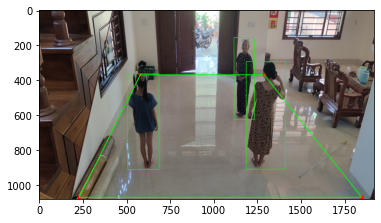

In [ ]:
image_2 = cv2.imread(os.path.join(MAE_data_folder,image_names[6]))
image_2 = cv2.resize(image_2,(1920,1080))
A = [580,370]
B = [1290,370]
C = [230,1070]
D = [1850,1070]
pts = np.array([A, C, D, B],np.int32)
isClosed = True
real_width, real_height = 4.25,4.8
cv2.circle(image_2,tuple(A),10,(0,0,255),-1)
cv2.circle(image_2,tuple(B),10,(0,0,255),-1)
cv2.circle(image_2,tuple(C),10,(0,0,255),-1)
cv2.circle(image_2,tuple(D),10,(0,0,255),-1)
cv2.polylines(image_2, [pts], isClosed, (0,255,0), 4)
boxes = darknet_helper(image_2, width, height)
for (xmin,ymin,xmax,ymax) in boxes:
    print(xmin,ymin,xmax,ymax)
    cv2.rectangle(image_2,(int(xmin),int(ymin)),(int(xmax),int(ymax)),(0,255,0),2)
plt.imshow(cv2.cvtColor(image_2,cv2.COLOR_BGR2RGB))

[[1124.99848447  507.48854328]
 [1134.77922804  791.74635732]
 [ 331.03939108  793.05572048]]


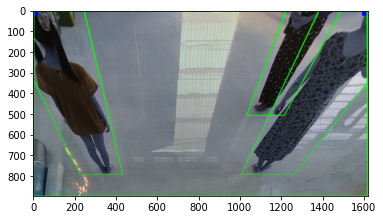

In [ ]:
M,pixel_width,pixel_height = MatrixCreation(A,B,C,D)
warped_points = cv2.warpPerspective(image_2,M,(pixel_width,pixel_height))
Transformed_Points = Points_Transformation(boxes)
print(Transformed_Points)
plt.imshow(warped_points)


In [ ]:
  print(Distance(Transformed_Points[1],Transformed_Points[2]))

3.75 5.0
867 901
2.465069774131612


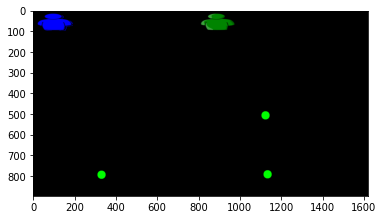

In [ ]:
  def get_birds_eye_view_image(transformed_points,eye_view_height,eye_view_width):
    blank_image = cv2.imread('/content/drive/MyDrive/Advanced-CV/black_background.png')
    blank_image = cv2.resize(blank_image,(eye_view_width,eye_view_height))
    for point in transformed_points:
        cv2.circle(blank_image,tuple(point.astype(int)),20,(0,255,0),-1)
    return blank_image

bird_eye_image = get_birds_eye_view_image(Transformed_Points,pixel_height,pixel_width)
plt.imshow(bird_eye_image)

#Tách video lấy frame -> ảnh

In [ ]:
%cd /content/drive/MyDrive/Advanced-CV/frame_vtest//

/content/drive/MyDrive/Advanced-CV/frame_vtest


In [ ]:
import time

cap = cv2.VideoCapture('/content/drive/MyDrive/Advanced-CV/vtest.avi')
if (cap.isOpened()==False):
    print('Error opening video stream or file')
else: 
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    count=0
    start = 0
    while (True):
       ret, frame = cap.read()
       if ret==True:
           if (start==0) or (time.time()-start>=0.05):
              cv2.imwrite("frame%d.jpg" % count,frame) 
              start = time.time()
              # plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
              # plt.show()
              print(count)
              count+=1 
           if cv2.waitKey(1)==ord('q'): break
         
       else: break
    #out.release()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
